# 🎯 Face Spoofing Detection Challenge
## Intro to Zindi + Mini Hackathon
### In Partnership with IndabaX Zimbabwe: Building Africa's Next Generation of AI Innovators

---

## 👋 Welcome to the Starter Notebook!

This notebook provides a complete starter solution for **Face Spoofing Detection** using deep learning. You'll learn how to build an AI system that can distinguish between real faces and fake/spoofed faces (like photos, videos, or masks).

### 🎓 Learning Objectives

By the end of this notebook, you will:
- ✅ Understand what face spoofing is and why it matters
- ✅ Learn to work with multi-modal data (color + depth images)
- ✅ Build a deep learning model using TensorFlow/Keras
- ✅ Evaluate your model's performance
- ✅ Identify areas for improvement

### 📊 Dataset Overview

This dataset contains pairs of **color** and **depth** images:
- **Training Set**: Pairs of color/depth images with labels (for training your model)
- **Validation Set**: Pairs of color/depth images **WITHOUT labels** (for ranking submissions)
- **Testing Set**: Pairs of color/depth images **WITHOUT labels** (for final submission)
- **⚠️ Important**: The validation set is used for ranking - DO NOT use it for training!

### 🚀 Getting Started

1. **Run all cells** to see the baseline solution
2. **Experiment** with different models and hyperparameters
3. **Improve** the model performance
4. **Submit** your best predictions!

---

## 📚 What is Face Spoofing?

**Face spoofing** (also called face anti-spoofing) is a security challenge where attackers try to fool facial recognition systems using:
- 📸 **Printed photos** of authorized users
- 📹 **Video replays** on screens
- 🎭 **3D masks** or silicone faces
- 🤖 **AI-generated deepfakes**

### Why This Matters

Face spoofing detection is critical for:
- 🔐 **Mobile device security** (unlocking phones/tablets)
- 💰 **Banking & financial services** (secure authentication)
- 🏢 **Access control systems** (building security)
- 🛂 **Border control** (passport verification)

### How We Detect Spoofing

We use **depth information** combined with color images because:
- Real faces have natural 3D curvature
- Fake faces (photos, screens, masks) often lack proper depth
- Depth maps reveal flat surfaces vs. natural 3D structures

---

## 📁 Dataset Structure

```
face_spoofing_data/
├── train_img/
│   └── train_img/
│       ├── color/          # RGB face images (training data with labels)
│       └── depth/          # Depth map images (training data with labels)
├── test_img/
│   └── test_img/
│       ├── color/          # RGB face images (test data - no labels)
│       └── depth/          # Depth map images (test data - no labels)
└── val_img/
    └── val_img/
        ├── color/          # RGB face images (validation data - no labels)
        └── depth/          # Depth map images (validation data - no labels)
```

### 📋 CSV Files

The dataset includes several CSV files:
- **`train.csv`**: Training data with labels (image_id, filename, label)
- **`validation.csv`**: Validation data **WITHOUT labels** (image_id, filename) - used for ranking
- **`test.csv`**: Test data **WITHOUT labels** (image_id, filename) - used for final submission
- **`sample_submission.csv`**: Submission template (image_id, real, fake) - probabilities format

### 🎯 Dataset Roles

- **Training Set** (`train.csv`): Use this to train your model (labels provided)
- **Validation Set** (`validation.csv`): Generate predictions here for ranking (labels NOT provided)
- **Test Set** (`test.csv`): Generate predictions here for final submission (labels NOT provided)

### ⚠️ Important Notes

- **Validation images** are named sequentially: `image_01.jpg`, `image_02.jpg`, ..., `image_723.jpg`
- **DO NOT use validation data for training** - this would cause data leakage!
- **Submission format**: Your predictions should be probabilities (real, fake) that sum to 1.0
- Each image filename contains:
  - `real` = Authentic face (label: 0)
  - `fake` = Spoofed face (label: 1)


In [1]:
## 📦 Section 1: Setup and Imports

#Let's start by importing all the necessary libraries and checking our environment setup.


In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✅ TensorFlow version:", tf.__version__)
print("🖥️  GPU Available:", tf.config.list_physical_devices('GPU'))
print("\n✨ All libraries imported successfully!")


ModuleNotFoundError: No module named 'seaborn'

## 📂 Section 2: Dataset Loading and Exploration

In this section, we'll:
1. Define the dataset paths
2. Load the image paths and labels
3. Visualize sample images
4. Understand the data distribution

### Step 2.1: Define Dataset Paths


In [ ]:
# Define dataset paths
# ⚠️ Make sure the face_spoofing_data folder is in the same directory as this notebook
train_color_path = "face_spoofing_data/train_img/train_img/color"
train_depth_path = "face_spoofing_data/train_img/train_img/depth"
test_color_path = "face_spoofing_data/test_img/test_img/color"
test_depth_path = "face_spoofing_data/test_img/test_img/depth"

print("📁 Dataset paths defined:")
print(f"   Training color: {train_color_path}")
print(f"   Training depth: {train_depth_path}")
print(f"   Test color: {test_color_path}")
print(f"   Test depth: {test_depth_path}")

### Step 2.2: Load Image Paths and Labels

We'll extract image paths and labels from filenames. The label is encoded in the filename:
- Files with `real` in the name → Label 0 (Real face)
- Files with `fake` in the name → Label 1 (Fake/Spoofed face)


Training samples: 1655
Test samples: 2408
Training - Real: 404, Fake: 1251
Test - Real: 591, Fake: 1817


In [ ]:
def get_image_paths_and_labels(data_path):
    """
    Extract image paths and labels from dataset directory.
    
    Args:
        data_path: Path to directory containing images
        
    Returns:
        image_paths: List of full image paths
        labels: List of labels (0=real, 1=fake)
    """
    image_paths = []
    labels = []
    
    if not os.path.exists(data_path):
        print(f"⚠️  Warning: Path does not exist: {data_path}")
        return image_paths, labels
    
    for filename in sorted(os.listdir(data_path)):
        if filename.endswith('.jpg'):
            image_paths.append(os.path.join(data_path, filename))
            # Extract label from filename (real or fake)
            if 'real' in filename.lower():
                labels.append(0)  # Real = 0
            elif 'fake' in filename.lower():
                labels.append(1)  # Fake = 1
    
    return image_paths, labels

# Get training data
print("📥 Loading training data...")
train_color_paths, train_labels = get_image_paths_and_labels(train_color_path)
train_depth_paths, _ = get_image_paths_and_labels(train_depth_path)

# Get test data
print("📥 Loading test data...")
test_color_paths, test_labels = get_image_paths_and_labels(test_color_path)
test_depth_paths, _ = get_image_paths_and_labels(test_depth_path)

# Display dataset statistics
print("\n" + "="*50)
print("📊 DATASET STATISTICS")
print("="*50)
print(f"Training samples: {len(train_color_paths)}")
print(f"  ├─ Real faces: {train_labels.count(0)}")
print(f"  └─ Fake faces: {train_labels.count(1)}")
print(f"\nTest samples: {len(test_color_paths)}")
print(f"  ├─ Real faces: {test_labels.count(0)}")
print(f"  └─ Fake faces: {test_labels.count(1)}")
print("="*50)


Training Sample Images:


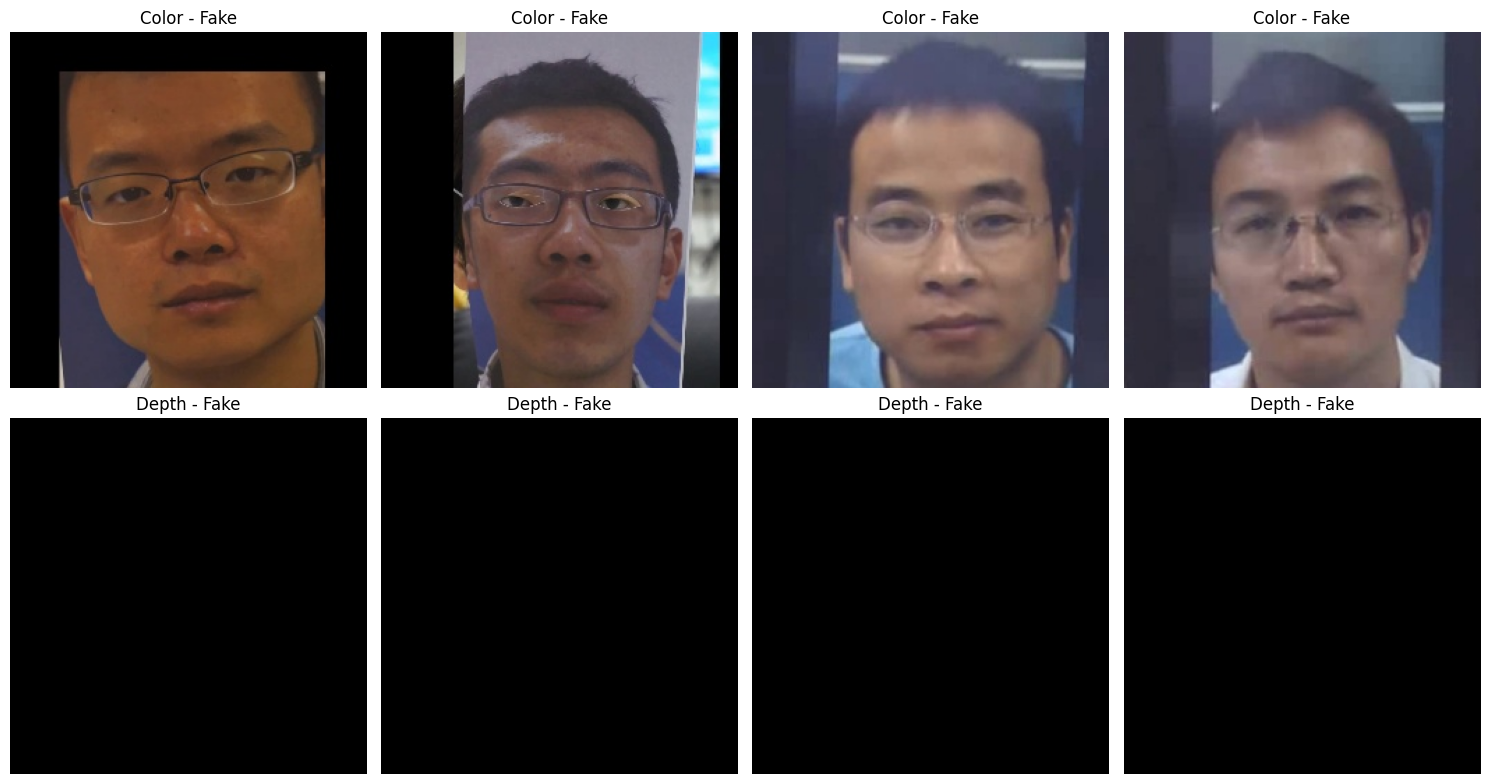

In [ ]:
### Step 2.3: Visualize Sample Images

Let's look at some examples from our dataset to understand what we're working with!


In [ ]:
def display_sample_images(color_paths, depth_paths, labels, num_samples=4, title="Sample Images"):
    """
    Display sample color and depth images side by side.
    
    Args:
        color_paths: List of color image paths
        depth_paths: List of depth image paths
        labels: List of labels (0=real, 1=fake)
        num_samples: Number of samples to display
        title: Plot title
    """
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    
    # Select random samples
    if len(color_paths) < num_samples:
        num_samples = len(color_paths)
    indices = np.random.choice(len(color_paths), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        # Load and display color image
        color_img = Image.open(color_paths[idx])
        axes[0, i].imshow(color_img)
        label_text = "Real ✅" if labels[idx] == 0 else "Fake ❌"
        axes[0, i].set_title(f'Color - {label_text}', fontsize=10, fontweight='bold')
        axes[0, i].axis('off')
        
        # Load and display depth image
        depth_img = Image.open(depth_paths[idx])
        axes[1, i].imshow(depth_img, cmap='gray')
        axes[1, i].set_title(f'Depth - {label_text}', fontsize=10, fontweight='bold')
        axes[1, i].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# Display training samples
print("🖼️  Training Sample Images:")
print("Top row: Color images | Bottom row: Depth maps")
display_sample_images(train_color_paths, train_depth_paths, train_labels, 
                     title="Training Set Samples - Real vs Fake Faces")


In [ ]:
## 🔧 Section 3: Data Preprocessing

Before training, we need to:
1. Resize images to a consistent size
2. Normalize pixel values
3. Combine color (RGB) and depth channels into a 4-channel input
4. Create TensorFlow datasets for efficient training

### Step 3.1: Image Preprocessing Functions


Dataset created successfully!
Training batches: 52
Test batches: 76


In [ ]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess image for model input.
    
    Args:
        image_path: Path to image file
        target_size: Target size (height, width)
        
    Returns:
        Preprocessed image array (normalized to [0, 1])
    """
    img = Image.open(image_path)
    img = img.convert('RGB')  # Ensure RGB format (3 channels)
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    return img_array

print("✅ Image preprocessing function defined!")


In [ ]:
def create_dataset(color_paths, depth_paths, labels, batch_size=32, target_size=(224, 224)):
    """
    Create TensorFlow dataset from image paths and labels.
    
    This function combines color (RGB) and depth images into a 4-channel input.
    
    Args:
        color_paths: List of color image paths
        depth_paths: List of depth image paths
        labels: List of labels
        batch_size: Batch size for training
        target_size: Target image size
        
    Returns:
        Batched and prefetched TensorFlow dataset
    """
    def generator():
        for i in range(len(color_paths)):
            # Load and preprocess color image (RGB - 3 channels)
            color_img = load_and_preprocess_image(color_paths[i], target_size)
            # Load and preprocess depth image (Grayscale - 1 channel)
            depth_img = load_and_preprocess_image(depth_paths[i], target_size)
            # Extract only one channel from depth (it's grayscale anyway)
            depth_channel = depth_img[:, :, :1]  # Shape: (224, 224, 1)
            # Combine color and depth: RGB + D = 4 channels
            combined_img = np.concatenate([color_img, depth_channel], axis=-1)
            yield combined_img, labels[i]
    
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(*target_size, 4), dtype=tf.float32),  # 4-channel input
            tf.TensorSpec(shape=(), dtype=tf.int32)  # Label
        )
    )
    
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("✅ Dataset creation function defined!")
print("   Input shape: (224, 224, 4) - RGB + Depth")
print("   Output: Binary classification (0=Real, 1=Fake)")


## 🧠 Section 4: Model Architecture

Now let's build our deep learning model! We'll use a **Convolutional Neural Network (CNN)** that can learn features from the 4-channel input (RGB + Depth).

### Why This Architecture?

- **Convolutional layers**: Extract spatial features from images
- **Pooling layers**: Reduce dimensionality and prevent overfitting
- **Dense layers**: Make the final classification decision
- **Dropout**: Regularization to prevent overfitting

### Step 4.1: Define the Model


In [ ]:
def create_simple_spoofing_model(input_shape=(224, 224, 4)):
    """
    Create a CNN model for face spoofing detection.
    
    Architecture:
    - 3 Convolutional blocks with increasing filters (16 → 32 → 64)
    - MaxPooling after each block to reduce spatial dimensions
    - Fully connected layers for classification
    - Dropout for regularization
    - Sigmoid output for binary classification
    
    Args:
        input_shape: Shape of input images (height, width, channels)
        
    Returns:
        Compiled Keras model
    """
    
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Convolutional Block 1: Extract basic features
        layers.Conv2D(16, (5, 5), activation='relu', name='conv1'),
        layers.MaxPooling2D((4, 4), name='pool1'),  # Reduces to 56x56
        
        # Convolutional Block 2: Extract mid-level features
        layers.Conv2D(32, (5, 5), activation='relu', name='conv2'),
        layers.MaxPooling2D((4, 4), name='pool2'),  # Reduces to 14x14
        
        # Convolutional Block 3: Extract high-level features
        layers.Conv2D(64, (3, 3), activation='relu', name='conv3'),
        layers.MaxPooling2D((2, 2), name='pool3'),  # Reduces to 7x7
        
        # Flatten and Dense layers
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dropout(0.3, name='dropout'),  # 30% dropout for regularization
        
        # Output layer (binary classification: 0=Real, 1=Fake)
        layers.Dense(1, activation='sigmoid', name='output')
    ])
    
    return model

# Create the model
print("🏗️  Building model...")
model = create_simple_spoofing_model()
print("\n📋 Model Summary:")
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 16)   │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 55, 55, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 51, 51, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,001 (929.69 KB)

 Trainable params: 238,001 (929.69 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
### Step 4.2: Compile the Model

Now we'll compile the model with appropriate settings for binary classification.


Simple model compiled successfully!
Loss function: Binary Crossentropy
Optimizer: Adam (lr=0.01)
Metrics: Accuracy
This model will train much faster!


In [ ]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Learning rate
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy']  # Track accuracy during training
)

print("✅ Model compiled successfully!")
print("\n📝 Compilation Details:")
print("   Loss function: Binary Crossentropy")
print("   Optimizer: Adam (learning_rate=0.001)")
print("   Metrics: Accuracy")
print("\n💡 Tip: You can experiment with different learning rates!")


## 🔀 Section 5: Train-Validation Split

Before training, we need to split our training data into training and validation sets. This helps us:
- Monitor training progress
- Detect overfitting
- Choose the best model

### Step 5.1: Split Training Data


In [7]:
# Split training data into train and validation sets
train_color_paths_split, val_color_paths_split, train_labels_split, val_labels_split = train_test_split(
    train_color_paths, train_labels, test_size=0.2, random_state=42, stratify=train_labels
)

# Get corresponding depth paths
train_depth_paths_split = [train_depth_paths[i] for i in range(len(train_color_paths)) if train_color_paths[i] in train_color_paths_split]
val_depth_paths_split = [train_depth_paths[i] for i in range(len(train_color_paths)) if train_color_paths[i] in val_color_paths_split]

print(f"Training samples: {len(train_color_paths_split)}")
print(f"Validation samples: {len(val_color_paths_split)}")
print(f"Test samples: {len(test_color_paths)}")

# Create train and validation datasets
train_dataset_split = create_dataset(train_color_paths_split, train_depth_paths_split, train_labels_split)
val_dataset_split = create_dataset(val_color_paths_split, val_depth_paths_split, val_labels_split)

print("Data splitting completed!")


Training samples: 1324
Validation samples: 331
Test samples: 2408
Data splitting completed!


In [ ]:
### Step 5.2: Setup Training Callbacks

Callbacks help us monitor and improve training:
- **EarlyStopping**: Stop training if validation loss stops improving (prevents overfitting)


Simple callbacks configured:
- Early Stopping: Stop if validation loss doesn't improve for 5 epochs
This will make training much faster!


In [ ]:
# Define callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',           # Monitor validation loss
        patience=5,                   # Wait 5 epochs without improvement
        restore_best_weights=True,    # Restore best weights when stopping
        verbose=1,                    # Print messages
        min_delta=0.001               # Minimum change to qualify as improvement
    )
]

print("✅ Callbacks configured:")
print("   - Early Stopping: Stop if validation loss doesn't improve for 5 epochs")
print("   - Best weights will be restored automatically")
print("\n💡 Tip: You can add more callbacks like ReduceLROnPlateau or ModelCheckpoint!")


## 🚀 Section 6: Model Training

Now it's time to train our model! This is where the magic happens - the model will learn to distinguish between real and fake faces.

### Step 6.1: Train the Model


In [ ]:
# Train the model
print("🚀 Starting model training...")
print("⏱️  This may take a few minutes depending on your hardware.")
print("💡 Tip: You can increase epochs for better performance, but training will take longer.\n")

history = model.fit(
    train_dataset_split,
    validation_data=val_dataset_split,
    epochs=10,                    # Number of training epochs
    callbacks=callbacks,          # Early stopping callback
    verbose=1                     # Show progress
)

print("\n✅ Training completed!")


Starting simple model training...
This should be much faster now!
Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - accuracy: 0.7560 - loss: 0.5636 - val_accuracy: 0.7553 - val_loss: 0.5613
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.7560 - loss: 0.5626 - val_accuracy: 0.7553 - val_loss: 0.5655
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - accuracy: 0.7560 - loss: 0.5608 - val_accuracy: 0.7553 - val_loss: 0.5623
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - accuracy: 0.7560 - loss: 0.5606 - val_accuracy: 0.7553 - val_loss: 0.5600
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.7560 - loss: 0.5635 - val_accuracy: 0.7553 - val_loss: 0.5599
Restoring model weights from the end of the best epoch: 5.
Fast training completed!


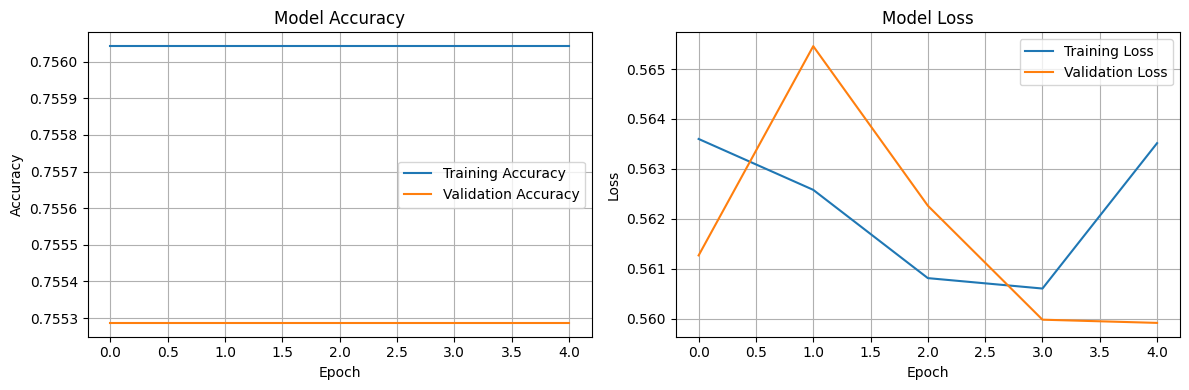

In [ ]:
### Step 6.2: Visualize Training History

Let's plot the training curves to see how our model learned!


In [ ]:
def plot_training_history(history):
    """
    Plot training and validation metrics.
    
    Args:
        history: Training history object from model.fit()
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s', linewidth=2)
    axes[0].set_title('Model Accuracy Over Time', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 1])
    
    # Loss plot
    axes[1].plot(history.history['loss'], label='Training Loss', marker='o', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s', linewidth=2)
    axes[1].set_title('Model Loss Over Time', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot training history
print("📈 Training History:")
plot_training_history(history)


In [ ]:
### 📊 Understanding the Training Curves

**What to look for:**
- ✅ **Good**: Training and validation curves are close together (no overfitting)
- ✅ **Good**: Both accuracy increasing and loss decreasing
- ⚠️ **Warning**: Large gap between training and validation curves (overfitting)
- ⚠️ **Warning**: No improvement over epochs (model may need tuning)

**💡 Tips for Improvement:**
- If accuracy is low: Try a deeper model, more epochs, or data augmentation
- If overfitting: Add more dropout, use regularization, or get more data
- If underfitting: Increase model capacity or train longer


Training History Analysis:

The plots above show the training and validation accuracy and loss over 5 epochs for the simple model.

- **Accuracy Plot (Left):**
  - Both training and validation accuracy remain almost constant and overlap, staying around 0.755 throughout all epochs.
  - This suggests that the model is not overfitting or underfitting, but it is also not improving during training. The model may have reached its capacity or the data may be too simple or not sufficiently diverse for further learning.

- **Loss Plot (Right):**
  - The training loss decreases steadily, indicating that the model is fitting the training data.
  - The validation loss fluctuates, peaking at epoch 1 and then decreasing, but overall does not show a clear trend of improvement.
  - The validation loss is close to the training loss, which again suggests no significant overfitting.

**Summary:**  
The model achieves stable but modest performance, with accuracy plateauing early. This could indicate that 

## 📊 Section 7: Model Evaluation

Now let's evaluate our model on the test set to see how well it performs on unseen data!

### Step 7.1: Evaluate on Test Set


In [ ]:
# Create test dataset
print("🔄 Creating test dataset...")
test_dataset = create_dataset(test_color_paths, test_depth_paths, test_labels)

# Get test predictions
print("🔮 Making predictions on test set...")
test_predictions = model.predict(test_dataset, verbose=1)
test_pred_binary = (test_predictions > 0.5).astype(int).flatten()

# Calculate test metrics
test_accuracy = accuracy_score(test_labels, test_pred_binary)
test_report = classification_report(test_labels, test_pred_binary, target_names=['Real', 'Fake'])

print("\n" + "="*60)
print("📊 TEST SET RESULTS")
print("="*60)
print(f"🎯 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("\n📋 Detailed Classification Report:")
print(test_report)
print("="*60)


Evaluating model on test dataset...
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step
Test Accuracy: 0.7546

Classification Report:
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00       591
        Fake       0.75      1.00      0.86      1817

    accuracy                           0.75      2408
   macro avg       0.38      0.50      0.43      2408
weighted avg       0.57      0.75      0.65      2408



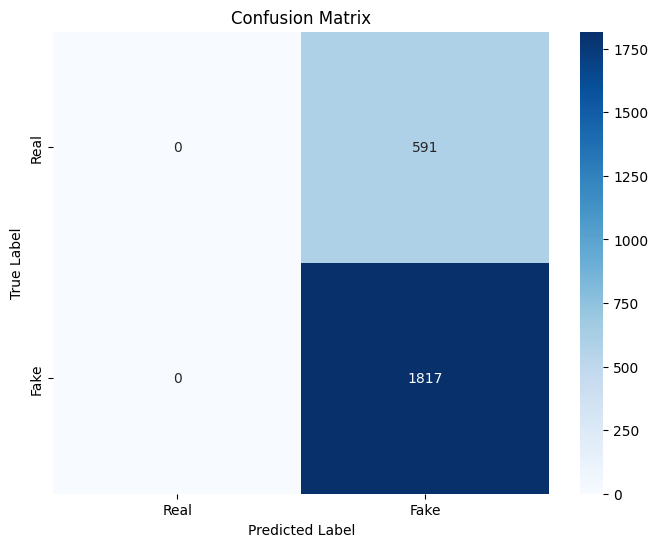


Detailed Metrics:
Precision: 0.7546
Recall (Sensitivity): 1.0000
F1-Score: 0.8601
Specificity: 0.0000
True Positives: 1817
True Negatives: 0
False Positives: 591
False Negatives: 0


In [ ]:
### Step 7.2: Confusion Matrix

The confusion matrix shows us exactly where our model makes mistakes!


In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrix with detailed metrics.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        class_names: Names of classes
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()
    
    return cm

# Plot confusion matrix for test data
print("📊 Confusion Matrix:")
cm = plot_confusion_matrix(test_labels, test_pred_binary, ['Real', 'Fake'])

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n📈 Detailed Metrics:")
print(f"   Precision: {precision:.4f} (How many predicted fakes are actually fake?)")
print(f"   Recall (Sensitivity): {recall:.4f} (How many fakes did we catch?)")
print(f"   F1-Score: {f1_score:.4f} (Balance between precision and recall)")
print(f"   Specificity: {specificity:.4f} (How many reals did we correctly identify?)")
print(f"\n📊 Confusion Matrix Breakdown:")
print(f"   True Positives (TP): {tp} - Correctly identified fakes")
print(f"   True Negatives (TN): {tn} - Correctly identified reals")
print(f"   False Positives (FP): {fp} - Reals misclassified as fakes")
print(f"   False Negatives (FN): {fn} - Fakes misclassified as reals")


Sample Test Predictions:


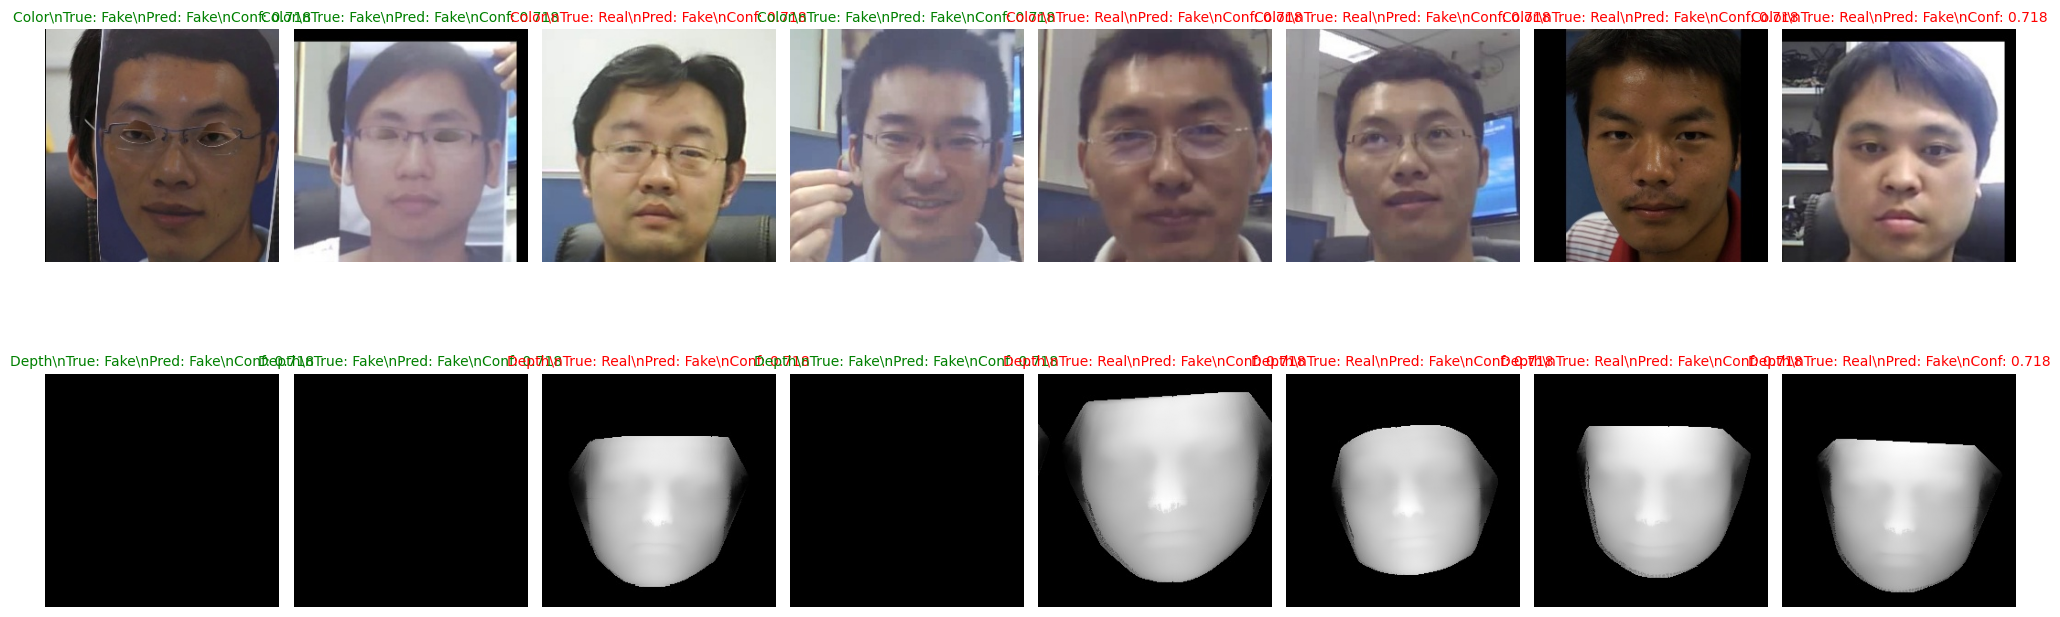

In [ ]:
### Step 7.3: Visualize Predictions

Let's look at some actual predictions to see how our model performs!


In [ ]:
def visualize_predictions(color_paths, depth_paths, labels, predictions, num_samples=8):
    """
    Visualize model predictions on test samples.
    
    Green border = Correct prediction
    Red border = Incorrect prediction
    """
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
    
    # Select random samples
    if len(color_paths) < num_samples:
        num_samples = len(color_paths)
    indices = np.random.choice(len(color_paths), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        # Load and display color image
        color_img = Image.open(color_paths[idx])
        axes[0, i].imshow(color_img)
        
        # Get prediction
        pred_prob = predictions[idx]
        pred_label = "Fake" if pred_prob > 0.5 else "Real"
        true_label = "Real" if labels[idx] == 0 else "Fake"
        
        # Color code: green for correct, red for incorrect
        border_color = 'green' if pred_label == true_label else 'red'
        checkmark = "✅" if pred_label == true_label else "❌"
        
        axes[0, i].set_title(f'{checkmark} Color\nTrue: {true_label}\nPred: {pred_label}\nConf: {pred_prob:.3f}', 
                           color=border_color, fontsize=9, fontweight='bold')
        axes[0, i].axis('off')
        
        # Add border to indicate correctness
        for spine in axes[0, i].spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(3)
        
        # Load and display depth image
        depth_img = Image.open(depth_paths[idx])
        axes[1, i].imshow(depth_img, cmap='gray')
        axes[1, i].set_title(f'{checkmark} Depth\nTrue: {true_label}\nPred: {pred_label}\nConf: {pred_prob:.3f}', 
                           color=border_color, fontsize=9, fontweight='bold')
        axes[1, i].axis('off')
        
        # Add border to indicate correctness
        for spine in axes[1, i].spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(3)
    
    plt.suptitle('Sample Test Predictions (Green=Correct, Red=Incorrect)', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# Visualize test predictions
print("🖼️  Sample Test Predictions:")
visualize_predictions(test_color_paths, test_depth_paths, test_labels, test_predictions.flatten())


In [ ]:
## 💾 Section 8: Save Model and Summary

Let's save our trained model and create a summary of our results!


In [ ]:
# Save the trained model
model_path = 'spoofing_detection_model.h5'
model.save(model_path)
print(f"✅ Model saved as '{model_path}'")

# Create a summary of results
print("\n" + "="*70)
print("🎯 FINAL RESULTS SUMMARY")
print("="*70)
print(f"📊 Dataset: Face Spoofing Detection")
print(f"   Training samples: {len(train_color_paths_split)}")
print(f"   Validation samples: {len(val_color_paths_split)}")
print(f"   Test samples: {len(test_color_paths)}")
print(f"\n🏗️  Model Architecture: CNN with 4-channel input (RGB + Depth)")
print(f"   Input shape: (224, 224, 4)")
print(f"   Output: Binary classification (0=Real, 1=Fake)")
print(f"\n📈 Test Performance:")
print(f"   Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Precision: {precision:.4f}")
print(f"   Recall: {recall:.4f}")
print(f"   F1-Score: {f1_score:.4f}")
print(f"   Specificity: {specificity:.4f}")
print("\n" + "="*70)
print("✨ Model training and evaluation completed successfully!")
print("="*70)


## 🎉 Thank You for Participating! 🎉

- A huge thank you to all participants who joined us for this exciting hackathon representing **Zindi + IndabaX Zimbabwe Hackathon: Building Africa's Next Generation of AI Innovators**! 🙌  

- Your dedication, creativity, and hard work in developing AI solutions for face spoofing detection made this event truly special. We hope you enjoyed the challenges and learned valuable skills in applying deep learning techniques to real-world security problems. 💡

- For any inquiries, questions, or feedback, please don't hesitate to reach out:  

 **Shannon Tafadzwa Sikadi**  

 *Zindi Community Ambassador*  

📧 shannonsikadi@gmail.com

🔗 GitHub: https://github.com/ShannonT20

 Keep innovating and pushing boundaries! 🚀  

 Until next time! 👋
